# **Predict Calorie Expenditure**

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
sample = pd.read_csv("data/sample_submission.csv")

In [3]:
test.head(5)

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8
1,750001,male,26,200.0,97.0,20.0,101.0,40.5
2,750002,female,29,188.0,85.0,16.0,102.0,40.4
3,750003,female,39,172.0,73.0,20.0,107.0,40.6
4,750004,female,30,173.0,67.0,16.0,94.0,40.5


In [4]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Sample shape:", sample.shape)

Train shape: (750000, 9)
Test shape: (250000, 8)
Sample shape: (250000, 2)


In [5]:
train.info()
train.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


,count,mean,std,min,25%,50%,75%,max
id,750000.0,374999.500000,216506.495284,0.0,187499.75,374999.5,562499.25,749999.0
Age,750000.0,41.420404,15.175049,20.0,28.00,40.0,52.00,79.0
Height,750000.0,174.697685,12.824496,126.0,164.00,174.0,185.00,222.0
Weight,750000.0,75.145668,13.982704,36.0,63.00,74.0,87.00,132.0
Duration,750000.0,15.421015,8.354095,1.0,8.00,15.0,23.00,30.0
Heart_Rate,750000.0,95.483995,9.449845,67.0,88.00,95.0,103.00,128.0
Body_Temp,750000.0,40.036253,0.779875,37.1,39.60,40.3,40.70,41.5
Calories,750000.0,88.282781,62.395349,1.0,34.00,77.0,136.00,314.0


In [6]:
train.isna().sum()

id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

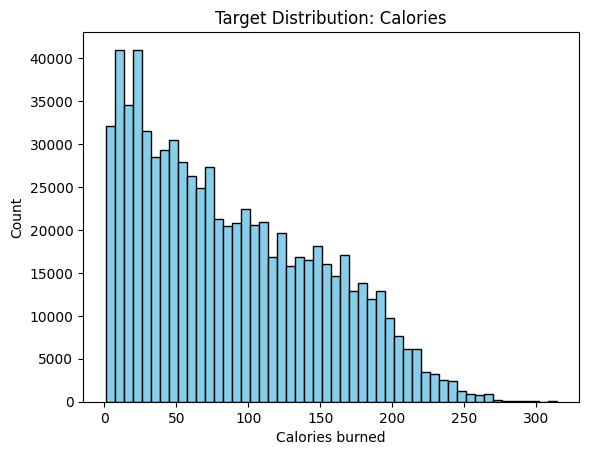

In [7]:
import matplotlib.pyplot as plt

plt.hist(train["Calories"], bins=50, color="skyblue", edgecolor="black")
plt.title("Target Distribution: Calories")
plt.xlabel("Calories burned")
plt.ylabel("Count")
plt.show()

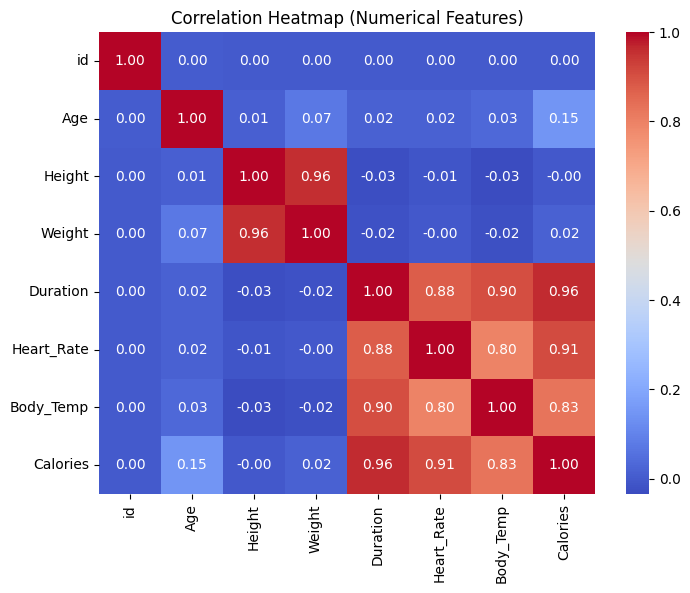

In [8]:
import seaborn as sns

num_cols = train.select_dtypes(include=['int64','float64']).columns
plt.figure(figsize=(8,6))
sns.heatmap(train[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

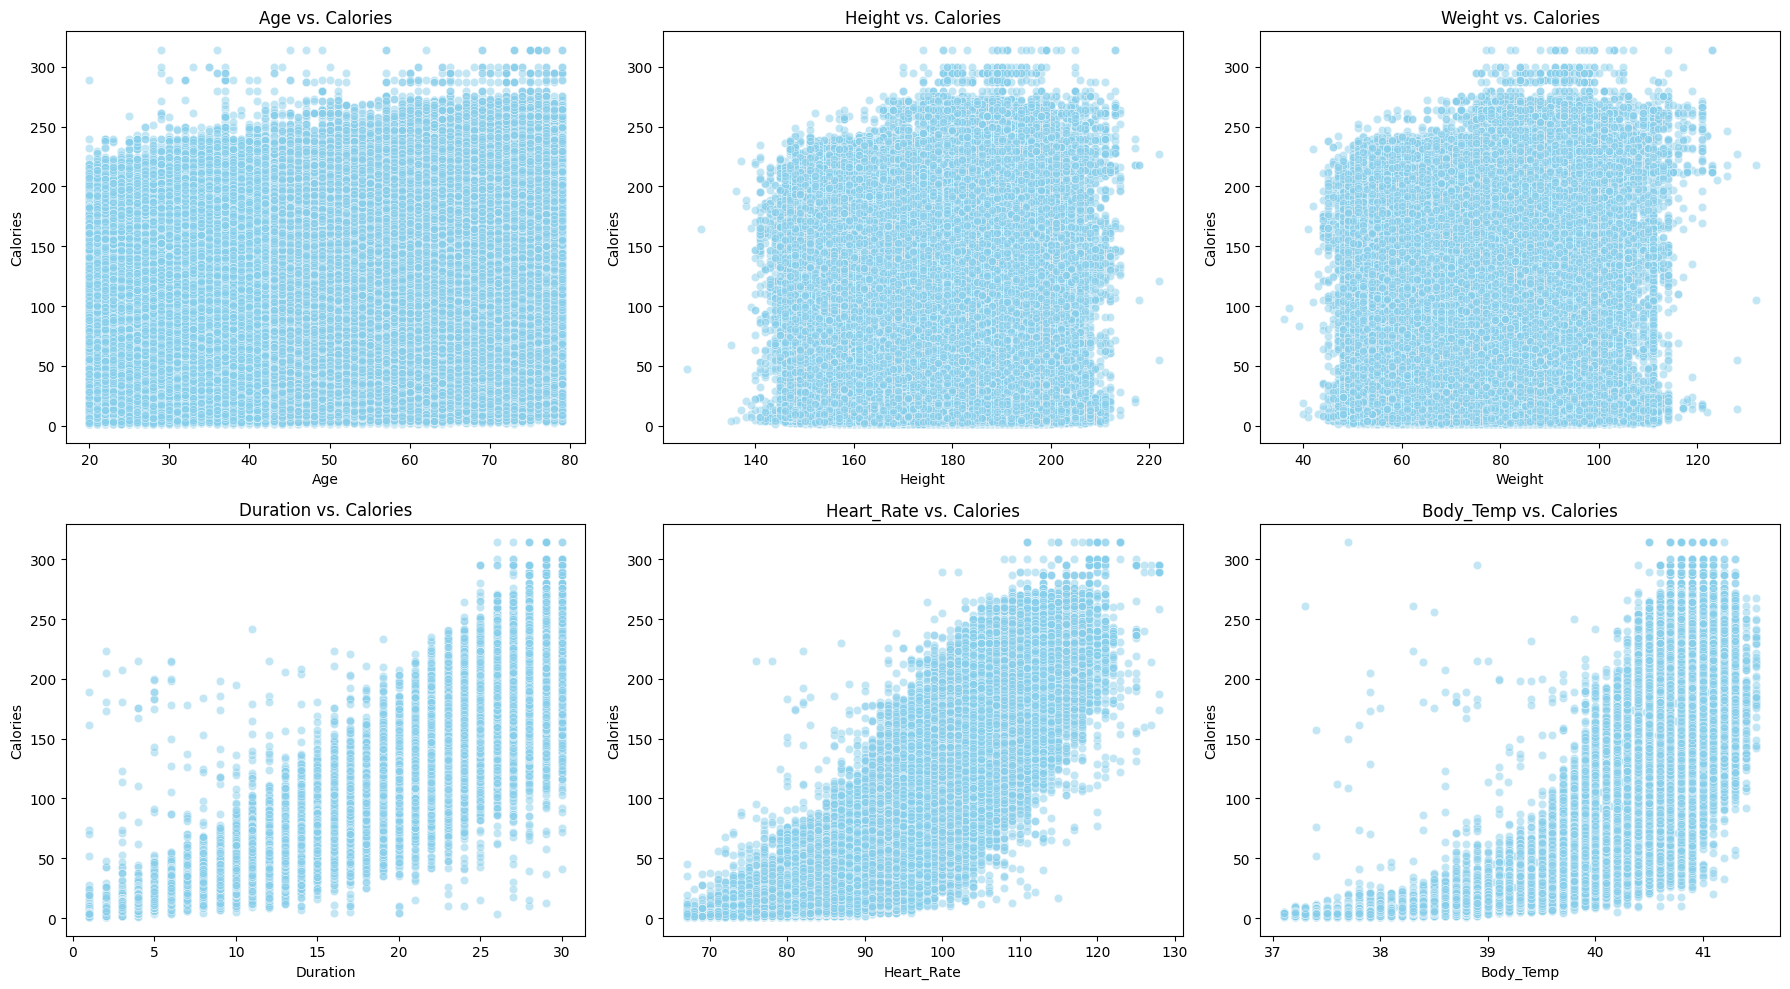

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18,10))
axes = axes.flatten()
numeric_features = ["Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp"] 
for i, col in enumerate(numeric_features):
    sns.scatterplot(data=train, x=col, y="Calories", ax=axes[i], alpha=0.5, color="skyblue")
    axes[i].set_title(f"{col} vs. Calories")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Calories")

plt.tight_layout()
plt.show()

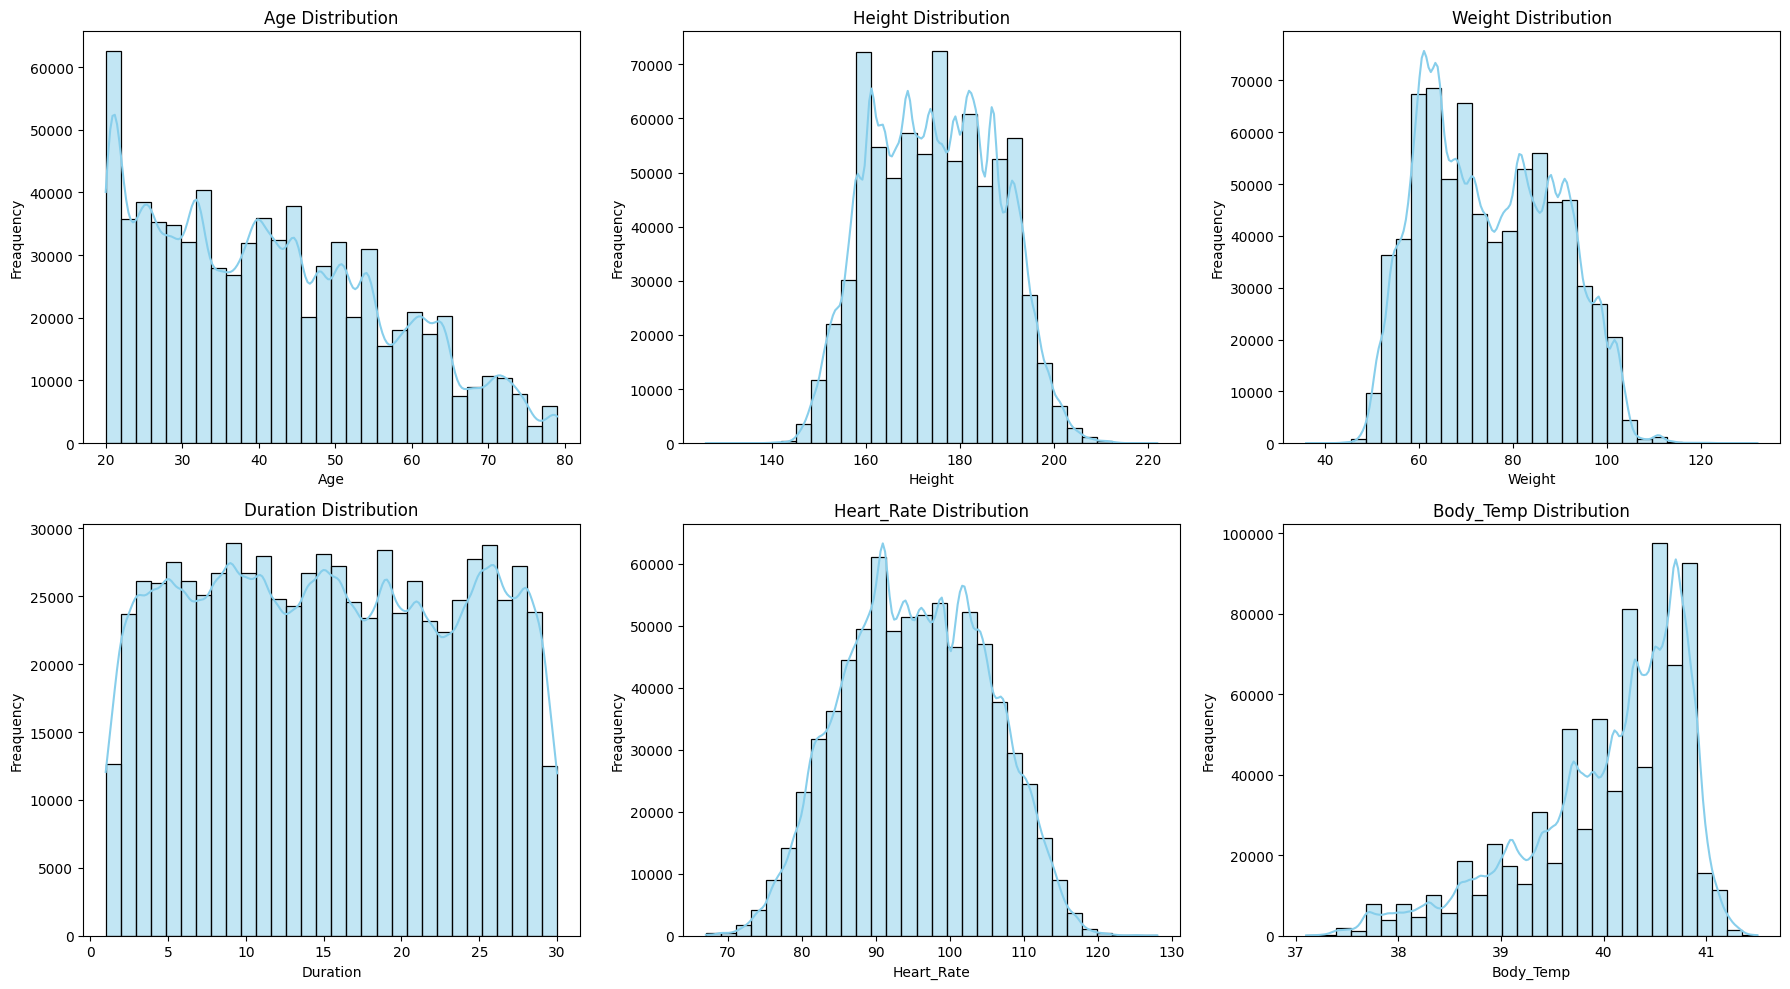

In [10]:
numeric_features = ["Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp"] 
fig, axes = plt.subplots(2, 3, figsize=(18,10)) 
axes = axes.flatten() 
for i, col in enumerate(numeric_features): 
    sns.histplot(data=train, x=col, bins=30, kde=True, ax=axes[i], color="skyblue") 
    axes[i].set_title(f"{col} Distribution") 
    axes[i].set_xlabel(col) 
    axes[i].set_ylabel("Freaquency")
plt.tight_layout() 
plt.show()

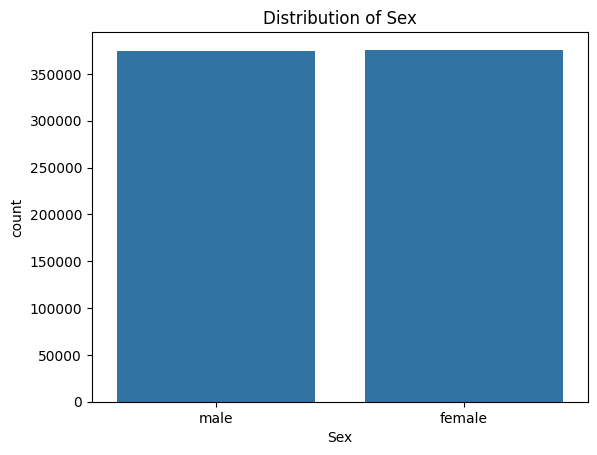

In [11]:
sns.countplot(data=train, x="Sex")
plt.title("Distribution of Sex")
plt.show()

### **Handling outliers**

In [12]:
train_clean = train.copy()
numeric_features = ["Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp"]
for col in numeric_features:
    Q1 = train_clean[col].quantile(0.25)
    Q3 = train_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    initial_shape = train_clean.shape[0]
    train_clean = train_clean[(train_clean[col] >= lower_bound) & (train_clean[col] <= upper_bound)]
    cleaned_count = initial_shape - train_clean.shape[0]
    print(f"'{col}': {cleaned_count} outliers removed.")

print(f"Final size of dataset after cleaning: {train_clean.shape}")


'Age': 0 outliers removed.
'Height': 14 outliers removed.
'Weight': 4 outliers removed.
'Duration': 0 outliers removed.
'Heart_Rate': 36 outliers removed.
'Body_Temp': 14919 outliers removed.
Final size of dataset after cleaning: (735027, 9)


# **Feature Engineering**

### **Adding features**

In [13]:
# Body Mass Index (BMI)
train_clean["BMI"] = train_clean["Weight"] / ((train_clean["Height"] / 100) ** 2)
test["BMI"] = test["Weight"] / ((test["Height"] / 100) ** 2)

# Duration relative to heart rate (efficiency metric)
train_clean["Duration_per_Heart"] = train_clean["Duration"] / train_clean["Heart_Rate"]
test["Duration_per_Heart"] = test["Duration"] / test["Heart_Rate"]

# Exercise intensity (interaction between heart rate and duration)
train_clean["Intensity"] = train_clean["Heart_Rate"] * train_clean["Duration"]
test["Intensity"] = test["Heart_Rate"] * test["Duration"]

# Body temperature per minute of exercise
train_clean["Temp_per_Minute"] = train_clean["Body_Temp"] / train_clean["Duration"]
test["Temp_per_Minute"] = test["Body_Temp"] / test["Duration"]

# Age Groups
train_clean['Age_Group'] = pd.cut(train_clean['Age'], bins=[0, 30, 45, 60, 100], labels=['18-30', '31-45', '46-60', '61+'])

#### **Feature engineer analysis**

In [14]:
train_clean.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI,Duration_per_Heart,Intensity,Temp_per_Minute,Age_Group
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0,22.955684,0.257426,2626.0,1.576923,31-45
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0,22.582709,0.094118,680.0,4.962500,61+
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0,24.690405,0.083333,588.0,5.685714,46-60
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0,24.414062,0.238095,2625.0,1.628000,18-30
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0,22.136740,0.245098,2550.0,1.624000,31-45


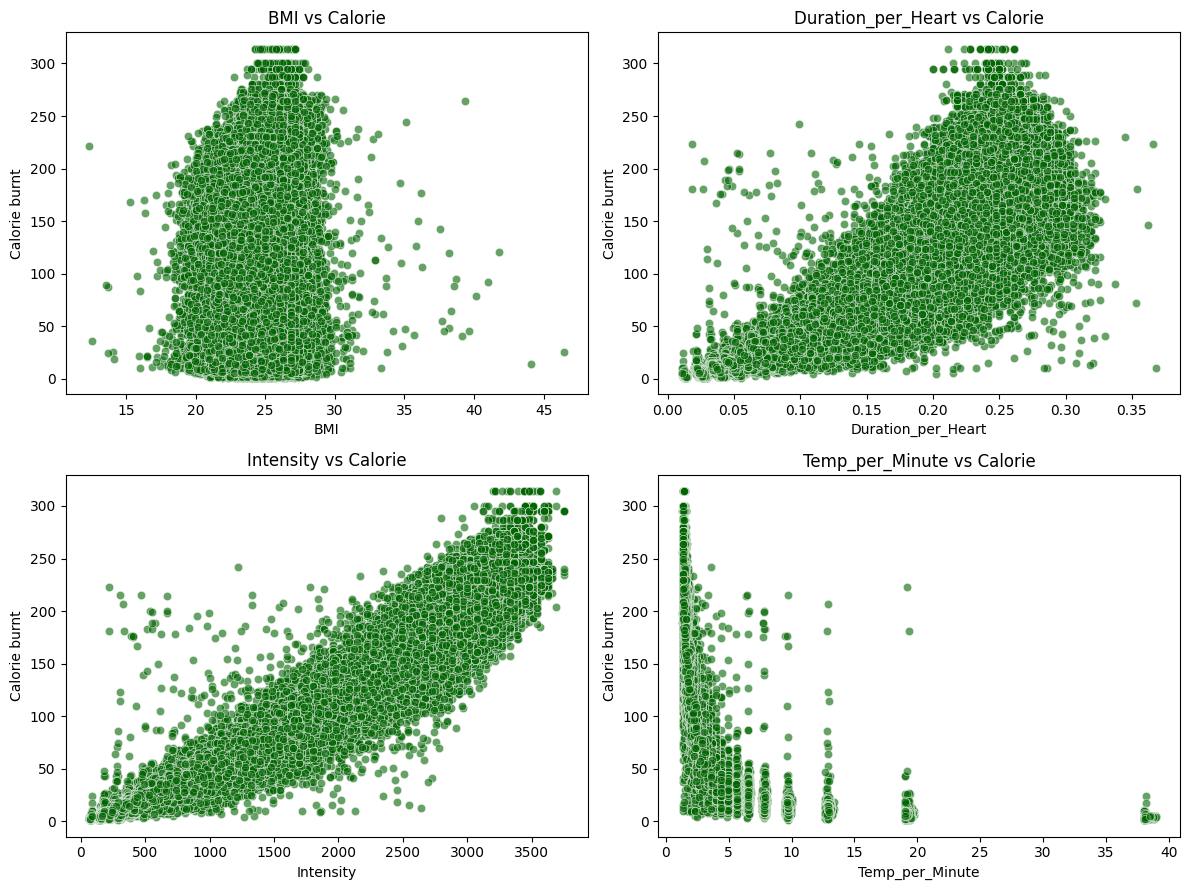

In [15]:
new_features = ["BMI", "Duration_per_Heart", "Intensity", "Temp_per_Minute"] 
fig, axes = plt.subplots(2, 2, figsize=(12,9)) 
axes = axes.flatten() 
for i, col in enumerate(new_features): 
    sns.scatterplot(
        data=train_clean,
        x=col, y="Calories",
        alpha=0.6, ax=axes[i], color="darkgreen",
    )
    axes[i].set_title(f"{col} vs Calorie")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Calorie burnt")

plt.tight_layout() 
plt.show()

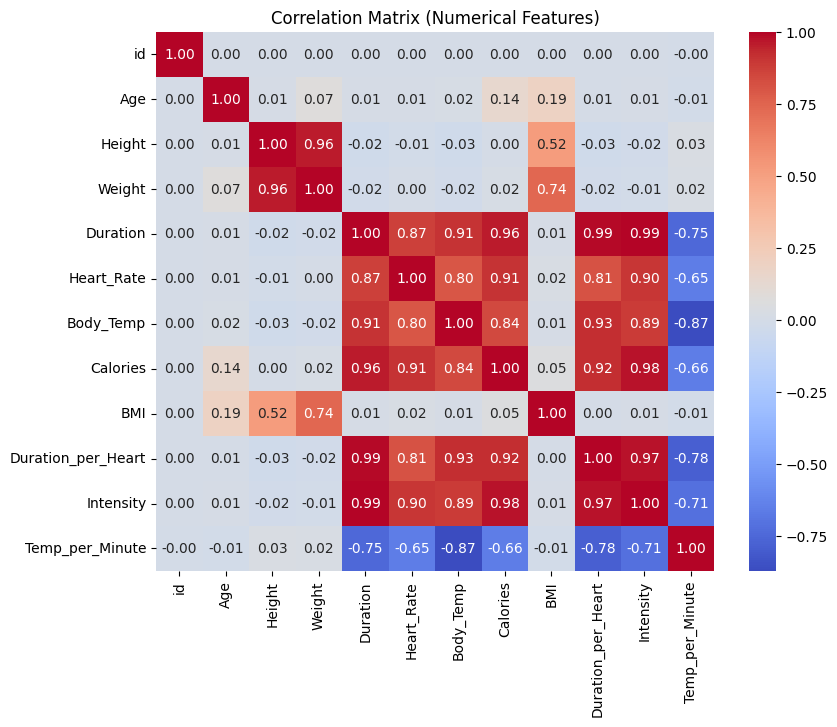

In [16]:
#Heat Map
num_cols = train_clean.select_dtypes(include=["int64","float64"]).columns
plt.figure(figsize=(9,7))
sns.heatmap(train_clean[num_cols].corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Numerical Features)")
plt.show()

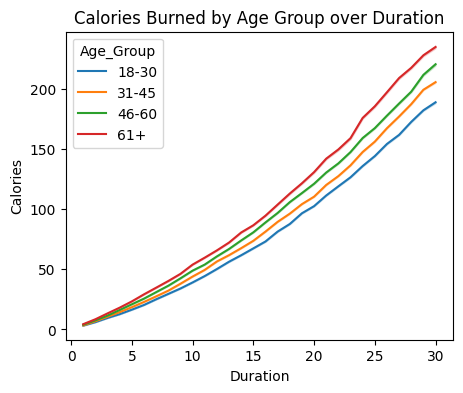

In [17]:
plt.figure(figsize=(5, 4))
sns.lineplot(data=train_clean, x='Duration', y='Calories', hue='Age_Group')
plt.title('Calories Burned by Age Group over Duration')
plt.show()

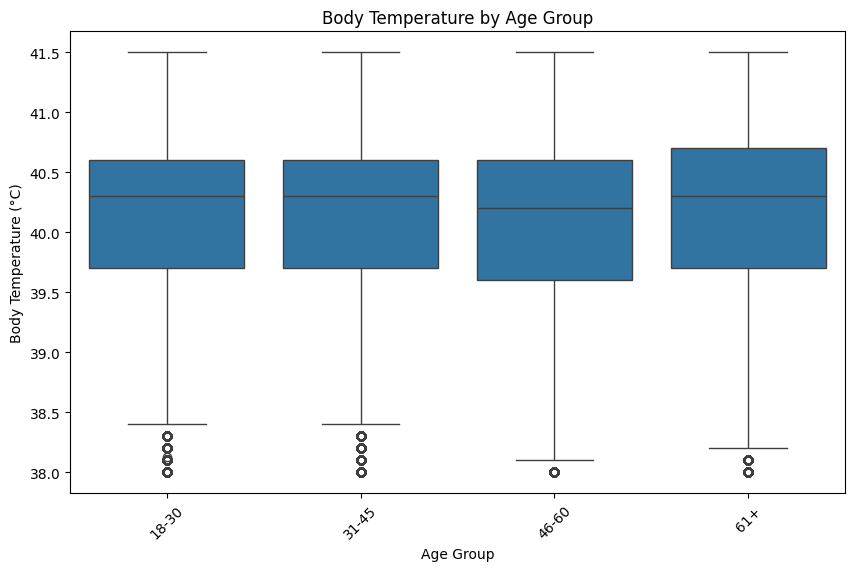

In [18]:
# box plot for Body Temperature by Age Group
plt.figure(figsize=(10, 6))
sns.boxplot(x='Age_Group', y='Body_Temp', data=train_clean)
plt.title('Body Temperature by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Body Temperature (°C)')
plt.xticks(rotation=45)
plt.show()

In [19]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 735027 entries, 0 to 749999
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   id                  735027 non-null  int64   
 1   Sex                 735027 non-null  object  
 2   Age                 735027 non-null  int64   
 3   Height              735027 non-null  float64 
 4   Weight              735027 non-null  float64 
 5   Duration            735027 non-null  float64 
 6   Heart_Rate          735027 non-null  float64 
 7   Body_Temp           735027 non-null  float64 
 8   Calories            735027 non-null  float64 
 9   BMI                 735027 non-null  float64 
 10  Duration_per_Heart  735027 non-null  float64 
 11  Intensity           735027 non-null  float64 
 12  Temp_per_Minute     735027 non-null  float64 
 13  Age_Group           735027 non-null  category
dtypes: category(1), float64(10), int64(2), object(1)
memory usage: 79.2+ MB


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNetCV, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# === Dữ liệu ===
X = train_clean.drop(columns=["Calories", "id"])
y = train_clean["Calories"]

numeric_features = [
    "Age", "Height", "Weight", "Duration", "Heart_Rate",
    "Body_Temp", "BMI", "Duration_per_Heart",
    "Intensity", "Temp_per_Minute"
]
categorical_features = ["Age_Group", "Sex"]

# === Chia train/test ===
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === Tiền xử lý chung cho các mô hình tuyến tính ===
numeric_linear = Pipeline(steps=[("scaler", StandardScaler())])
categorical_common = Pipeline(steps=[("onehot", OneHotEncoder(drop="first"))])

preprocessor_linear = ColumnTransformer(
    transformers=[
        ("num", numeric_linear, numeric_features),
        ("cat", categorical_common, categorical_features)
    ]
)

# === Các mô hình ===
models = {
    "LinearRegression": Pipeline([
        ("preprocessor", preprocessor_linear),
        ("model", LinearRegression())
    ]),
    "ElasticNet": Pipeline([
        ("preprocessor", preprocessor_linear),
        ("model", ElasticNetCV(
            l1_ratio=[.2, .5, .8, 1.0],
            cv=5,
            random_state=42,
            max_iter=10000
        ))
    ]),
    "Ridge": Pipeline([
        ("preprocessor", preprocessor_linear),
        ("model", RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5))
    ])
}

# === Huấn luyện & đánh giá ===
results = []
for name, pipe in models.items():
    try:
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_valid)

        rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
        r2 = r2_score(y_valid, y_pred)
        results.append((name, rmse, r2))

        print(f"{name:20s} → RMSE: {rmse:.2f}, R²: {r2:.3f}")
    except Exception as e:
        print(f"{name:20s} → Lỗi: {e}")

# === So sánh kết quả ===
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "R²"]).sort_values("RMSE")
print("\nKết quả so sánh mô hình:")
print(results_df)

# === Huấn luyện lại mô hình tốt nhất ===
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]
best_model.fit(X, y)

print(f"\n Mô hình tốt nhất ({best_model_name}) đã được huấn luyện lại trên toàn bộ dữ liệu.")


LinearRegression     → RMSE: 7.78, R²: 0.984
ElasticNet           → RMSE: 8.10, R²: 0.983
Ridge                → RMSE: 7.78, R²: 0.984

Kết quả so sánh mô hình:
              Model      RMSE        R²
0  LinearRegression  7.782936  0.984201
2             Ridge  7.782965  0.984201
1        ElasticNet  8.103667  0.982872

 Mô hình tốt nhất (LinearRegression) đã được huấn luyện lại trên toàn bộ dữ liệu.


In [21]:
from pathlib import Path
import joblib

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(exist_ok= True)

MODEL_PATH = ARTIFACTS_DIR/"best_calorie_model.pkl"

joblib.dump(best_model, MODEL_PATH)

print(f"Đã lưu model vào: {MODEL_PATH}")

Đã lưu model vào: artifacts\best_calorie_model.pkl
